In [2]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 加上一个 EOS 标记

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读入文件 filename, 分行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 建立一个词典 category_lines = {category: lines} , lines = [names...]
category_lines = {}
all_categories = []
for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0 :
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')



In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# category 的 one-hot编码
def categoryTensor(category):
    '''
    Convert three categories into one-hot encoding
    '''
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor.to(device)

# input 的 one-hot编码 ，从第一个字母到最后一个字母（不包含 EOS）
def inputTensor(line):
    '''
    Converts the input string into the corresponding 3D tensor
    '''
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor.to(device)

# output 的 one-hot编码 ，从第二个字母到最后的 EOS 符
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li])for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) # EOS的索引
    return torch.LongTensor(letter_indexes).to(device)


cuda:0


In [4]:
import random

def randomChoice(l):
    '''
    Select a random element from the array l
    '''
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    '''
    A random sample of a category is used to sample a random name 
    from that category
    '''
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# 从一个随机采样的 category-line 对中构建训练样本
# 包含 category 的tensor, input 的 tensor, 和 target 的 tensors 
def randomTrainingExample():
    category, line = randomTrainingPair()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    # Tensors of categories
    # the one-hot encoding of the string
    # The index vector of each character in the string in the all_letters list
    return input_line_tensor, target_line_tensor


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__() 
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        #    Initialize the weight matrix
        # 使用nn.Parameter来定义需要优化的权重
        self.W = nn.Parameter(torch.rand(hidden_size, hidden_size) * 0.01)
        self.U = nn.Parameter(torch.rand(input_size, hidden_size) * 0.01)
        self.V = nn.Parameter(torch.rand(hidden_size, output_size) * 0.01)
        self.b = nn.Parameter(torch.rand(hidden_size) * 0.01)
        self.c = nn.Parameter(torch.rand(output_size) * 0.01)
        
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = torch.matmul(hidden, self.W) + torch.matmul(input, self.U) + self.b
        hidden = torch.tanh(hidden)
        output = torch.matmul(hidden, self.V) + self.c
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [7]:
def progress(num):
    p = int(num / 5)
    s = '[' + '#'*p + '-'*(20-p)  + ']'
    return s

In [8]:
import time

def timeSince(since):
    now = time.time()
    s = now-since
    return '%dm %ds'%(s//60,s%60)

n_iters = 100000
print_every = 5000
plot_every = 500

all_losses = []
total_loss = 0

# The size of the hidden layer
n_hidden = 128
# 创建了一个RNN模型
# 输入维度为n_letters 隐藏层维度为n_hidden 输出维度为n_letters
rnn = RNN(n_letters, n_hidden, n_letters)
rnn = rnn.to(device)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        s = '%s %.4f' % (timeSince(start), loss)
        s += progress(iter/n_iters*100)
        print(s)
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0


0m 27s 2.7112[#-------------------]
0m 53s 2.9743[##------------------]
1m 20s 3.0913[###-----------------]
1m 45s 2.7926[####----------------]
2m 13s 3.6792[#####---------------]
2m 38s 2.8554[######--------------]
3m 4s 2.9848[#######-------------]
3m 30s 2.7743[########------------]
3m 55s 2.6547[#########-----------]
4m 21s 3.1224[##########----------]
4m 48s 2.4787[###########---------]
5m 15s 2.3743[############--------]
5m 43s 2.5643[#############-------]
6m 9s 3.3734[##############------]
6m 36s 2.9399[###############-----]
7m 2s 2.0685[################----]
7m 28s 2.9106[#################---]
7m 54s 2.7266[##################--]
8m 20s 2.5275[###################-]
8m 48s 3.5042[####################]


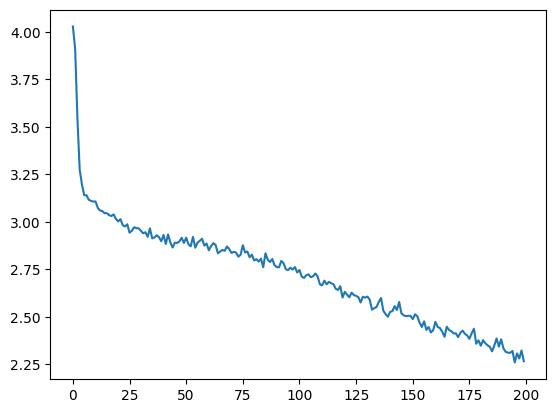

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [10]:
def split_string(string): return [char for char in string]

In [11]:
max_length = 20
def build_name(start_string = 'A'):
    #   Top five predictions for each moment
    input_num = len(start_string)
    letters = split_string(start_string)
    preds = [[i] for i in letters]
    num = len(letters)

    with torch.no_grad():

        inputs = [inputTensor(i) for i in letters]
        hidden = rnn.initHidden()
        
        # Initialize the output name as the starting letter
        output_name = start_string

        for i in range(max_length):
            if i < num :
                input = inputs[i]
            output, hidden = rnn(input[0],hidden)

            if i + 1 < num :
                #   如果还有字符等待处理
                pass
            else:
                #   如果字符已经处理完毕
        
                _, topi = output.topk(5)
                topi = topi[0]

                topi1 = topi[0]
                if topi1 == n_letters - 1 :
                    break
                else:
                    letter = all_letters[topi1]
                    output_name += letter

                    topi = [all_letters[i] if i < len(all_letters) else 'EOS' for i in topi]
                    
                    preds.append(topi)
                    
                input = inputTensor(letter)

    return output_name, preds, input_num

In [12]:
def draw(output_name, data, input_num):
    ''' Map the prediction process '''
    # Preprocess the input list named data
    for i in range(input_num):
        for j in range(4):
            data[i].append(' ')

    print('------  ========  ------\n')
    print(f'The final name is {output_name}\n')
    print('------  ========  ------\n')
    num_data = len(data)
    line1 = '=====\t' * (num_data + 1) +'\n'
    _line2 = ''
    for j in range(5):
        for i in range(num_data):
            if j > 0 :
                if data[i][j] != 'EOS':
                    _line2 += '  x  \t'.replace('x', data[i][j])
                else:
                    _line2 += '  x  \t'.replace(' x ', data[i][j])
            else:
                if data[i][j] != 'EOS':
                    _line2 += '  x   > '.replace('x', data[i][j])
                else:
                    _line2 += '  x   > '.replace(' x ', data[i][j])

                if i == num_data - 1 :
                    _line2 += ' EOS '
                
        _line2 += '\n'
        

    print(line1)
    print(_line2)
    print(line1)
    

In [14]:
input_chars = 'Ar'
draw(*build_name(input_chars))

------  ========  ------

The final name is Arie

------  ========  ------

=====	=====	=====	=====	=====	

  A   >   r   >   i   >   e   >  EOS 
     	     	  d  	  n  	
     	     	  l  	  a  	
     	     	  o  	  s  	
     	     	  e  	  c  	

=====	=====	=====	=====	=====	

